<a href="https://colab.research.google.com/github/ranjeetkumar/user_utterance_classifier/blob/main/classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**User utterance identifier**[link text](https://)

All imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD


from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from transformers import BertTokenizer, BertModel
import torch



Read the csv file



In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
df = pd.read_csv('drive/MyDrive/utterance_id.csv')

In [ ]:
df

,Unnamed: 0,question,tags
0,0,List email from Richa?,Email
1,1,What did robert write to me regarding overview...,Email
2,2,When was the Diwali Celeberation?,Email
3,3,Show me all emails focused on covid19.,Email
4,4,Show me the important mails for today,Email
...,...,...,...
4592,4592,Heuristic,Keyword
4593,4593,Kaiser Permanente,Keyword
4594,4594,bharat kumar malviya,Keyword
4595,4595,Rental agreement,Keyword


In [ ]:
df = df[['question','tags']]

In [ ]:
print(df.head())

                                            question   tags
0                             List email from Richa?  Email
1  What did robert write to me regarding overview...  Email
2                  When was the Diwali Celeberation?  Email
3             Show me all emails focused on covid19.  Email
4              Show me the important mails for today  Email


Stats of data

In [ ]:
df.describe()

,question,tags
count,4597,4597
unique,4439,7
top,total number of active agreements,Contract
freq,9,1590


Value Counts for 'tags':
tags
Contract    1590
Email       1162
Calendar     786
Contact      450
Document     398
Employee     126
Keyword       85
Name: count, dtype: int64


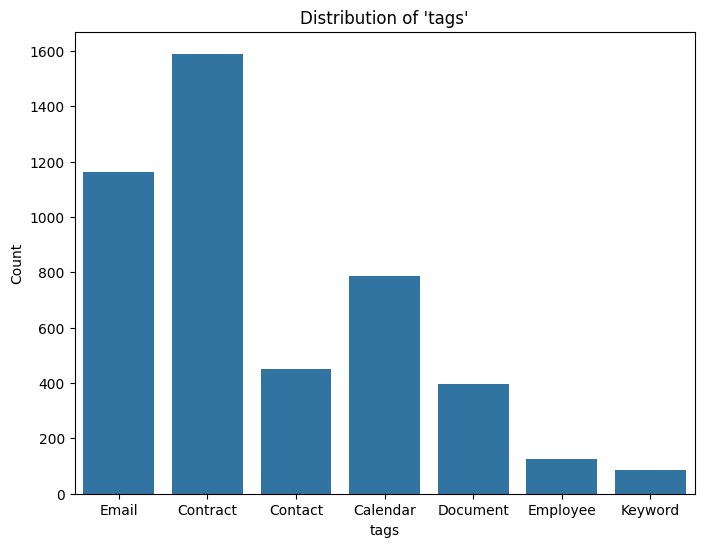

In [ ]:

column = 'tags'

# 1. Value Counts
print(f"Value Counts for '{column}':")
print(df[column].value_counts())

# 2. Distribution (Bar Plot)


plt.figure(figsize=(8, 6))
sns.countplot(x=df[column])
plt.title(f"Distribution of '{column}'")
plt.xlabel(column)
plt.ylabel("Count")
plt.show()

Feature Engineering

Missing Value

In [ ]:
missing_data = df.isnull().sum()

print("Missing Data in Each Column:")
print(missing_data)

# Alternatively, you can display only the columns with missing data
missing_data_filtered = missing_data[missing_data > 0]

print("\nColumns with Missing Data:")
print(missing_data_filtered)


Missing Data in Each Column:
question    0
tags        0
dtype: int64

Columns with Missing Data:
Series([], dtype: int64)


Duplicates

In [ ]:
duplicates = df[df.duplicated(keep=False)]

In [ ]:
print (duplicates)

                                               question      tags
37    What was the conversation with Neerose based on ?     Email
46    Who was the mail about business strategy sent to?     Email
51    What was the conversation with Neerose based on ?     Email
227                         how many mails with richa ?     Email
263             How long ago did michael send an email?     Email
...                                                 ...       ...
4319  What is the beam line made of in the IPF project?  Document
4323       What are the assumptions of the aglmix tool?  Document
4324       In which countries are there Walmart stores?  Document
4364       In which countries are there Walmart stores?  Document
4376                    What is an ordinarily resident?  Document

[277 rows x 2 columns]


In [ ]:
df_unique = df.drop_duplicates(keep="first")

In [ ]:
print(df_unique)

                                               question     tags
0                                List email from Richa?    Email
1     What did robert write to me regarding overview...    Email
2                     When was the Diwali Celeberation?    Email
3                Show me all emails focused on covid19.    Email
4                 Show me the important mails for today    Email
...                                                 ...      ...
4592                                          Heuristic  Keyword
4593                                  Kaiser Permanente  Keyword
4594                               bharat kumar malviya  Keyword
4595                                   Rental agreement  Keyword
4596                                               gfds  Keyword

[4441 rows x 2 columns]


Value Counts for 'tags':
tags
Contract    1590
Email       1162
Calendar     786
Contact      450
Document     398
Employee     126
Keyword       85
Name: count, dtype: int64


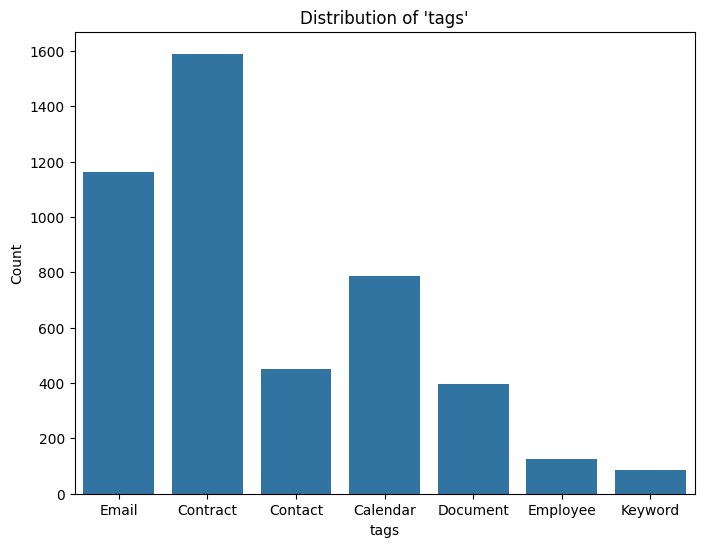

In [ ]:

column = 'tags'

# 1. Value Counts
print(f"Value Counts for '{column}':")
print(df[column].value_counts())

# 2. Distribution (Bar Plot)


plt.figure(figsize=(8, 6))
sns.countplot(x=df[column])
plt.title(f"Distribution of '{column}'")
plt.xlabel(column)
plt.ylabel("Count")
plt.show()

In [ ]:
X = df_unique['question']
y = df_unique['tags']


In [ ]:


# Download the stopwords from nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Text normalization and stop word removal function
def normalize_text(text):
    # Lowercase the text
    text = text.lower()

    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove stop words
    text = ' '.join([word for word in text.split() if word not in stop_words])

    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
print(stop_words)

{'o', 'more', 'an', 'both', 'shouldn', 'their', 'couldn', 'few', 'your', 'off', 'wouldn', "it's", 'haven', 'or', 'for', 're', "you'll", 'out', 'below', 'between', 'himself', 'ma', 'a', "you've", 'any', 'some', 'myself', 'needn', "wasn't", "shouldn't", 'such', 'me', 'did', 'own', 'no', 'into', 'had', 'not', 'while', 'mightn', 'as', 'didn', 'yourself', 'hers', "doesn't", 'on', 'where', 'when', 'other', "weren't", 'above', "haven't", 'very', 'is', 'ourselves', 'nor', "that'll", 'because', 'then', 'than', 'being', 'once', "mightn't", 'why', 'having', "needn't", 'now', 'were', 'the', 'of', 'it', "hadn't", 'at', "don't", 'be', 'so', 'his', 'themselves', 'd', 'won', 'but', 'and', 'just', 'these', 'in', 'there', 'has', 'down', 'only', 'to', 'up', 'who', 'we', "you'd", "you're", 'him', 'don', 'over', "aren't", "isn't", 'hadn', 'after', 'those', 'she', 'shan', 'whom', 'further', 'been', 'does', 'if', 'here', 'each', 'that', 'most', 'under', 'aren', 'you', 'again', 'can', "hasn't", 'll', 'have', 

In [ ]:
X_normalize = df_unique['question'].apply(normalize_text)

# Display the first few rows to check the normalization
print(X_normalize.head())

0                           list email richa
1    robert write regarding overview product
2                        diwali celeberation
3                  show emails focused covid
4                 show important mails today
Name: question, dtype: object


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train_nor, X_test_nor, y_train, y_test = train_test_split(X_normalize, y, test_size=0.2, random_state=42)

Model evaluation

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

MultinomialNB()

Not normalized

In [ ]:

y_pred = model.predict(X_test_tfidf)


# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))



Accuracy: 0.8605

Classification Report:
              precision    recall  f1-score   support

    Calendar       0.89      0.90      0.90       142
     Contact       0.90      0.73      0.80        84
    Contract       0.85      0.99      0.92       300
    Document       0.96      0.28      0.44        78
       Email       0.83      0.97      0.90       238
    Employee       1.00      0.81      0.89        31
     Keyword       0.00      0.00      0.00        16

    accuracy                           0.86       889
   macro avg       0.77      0.67      0.69       889
weighted avg       0.85      0.86      0.84       889


Confusion Matrix:
[[128   0   0   0  14   0   0]
 [  2  61   7   0  14   0   0]
 [  0   3 297   0   0   0   0]
 [ 11   2  28  22  15   0   0]
 [  3   1   2   0 232   0   0]
 [  0   0   5   0   1  25   0]
 [  0   1  10   1   4   0   0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Normalized data

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train_nor)
X_test_tfidf = vectorizer.transform(X_test_nor)

model = MultinomialNB()
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)


# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.8718

Classification Report:
              precision    recall  f1-score   support

    Calendar       0.90      0.94      0.92       142
     Contact       0.90      0.64      0.75        84
    Contract       0.87      0.99      0.93       300
    Document       0.97      0.41      0.58        78
       Email       0.83      0.97      0.89       238
    Employee       1.00      0.90      0.95        31
     Keyword       0.00      0.00      0.00        16

    accuracy                           0.87       889
   macro avg       0.78      0.69      0.72       889
weighted avg       0.86      0.87      0.85       889


Confusion Matrix:
[[133   0   0   0   9   0   0]
 [  1  54   5   0  24   0   0]
 [  0   1 298   0   1   0   0]
 [  8   2  27  32   9   0   0]
 [  5   2   1   0 230   0   0]
 [  0   0   3   0   0  28   0]
 [  0   1  10   1   4   0   0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import pandas as pd
import time

# Load the CSV file
df = pd.read_csv('drive/MyDrive/utterance_id.csv')  # Replace with the path to your CSV file

# Prepare a test dataset with 10 samples
test_samples = df.sample(10, random_state=42)  # Sample 10 rows randomly

# Extract questions and actual tags
questions = test_samples['question'].tolist()  # Assuming 'question' is the column name
actual_tags = test_samples['tags'].tolist()  # Assuming 'tags' is the column name

# Function to predict a list of texts and measure time per prediction
def predict_multiple_with_timing(texts):
    predictions = []
    times = []

    for text in texts:
        text = normalize_text(text)
        text = vectorizer.transform([text])
        start_time = time.time()
        predicted_label = model.predict(text)  # Call the predict function for each text
        end_time = time.time()

        predictions.append(predicted_label)
        times.append(end_time - start_time)

    return predictions, times

# Get predictions and time taken for each
predicted_tags, prediction_times = predict_multiple_with_timing(questions)

# Calculate average time per prediction
average_time_per_prediction = sum(prediction_times) / len(prediction_times)

# Print the predictions, actual tags, and the average time per prediction
for i, (question, actual_tag, predicted_tag, prediction_time) in enumerate(zip(questions, actual_tags, predicted_tags, prediction_times)):
    print(f"Sample {i+1}:")
    print(f"Question: {question}")
    print(f"Actual Tag: {actual_tag}")
    print(f"Predicted Tag: {predicted_tag}")
    print(f"Time Taken: {prediction_time:.4f} seconds\n")

print(f"Average Time per Prediction: {average_time_per_prediction:.4f} seconds")

Sample 1:
Question: where does morgan work?
Actual Tag: Contract
Predicted Tag: ['Contact']
Time Taken: 0.0002 seconds

Sample 2:
Question: What is Maithali's email ?
Actual Tag: Contact
Predicted Tag: ['Email']
Time Taken: 0.0002 seconds

Sample 3:
Question: where is Deloitte Tax LLP's office?
Actual Tag: Contract
Predicted Tag: ['Contract']
Time Taken: 0.0002 seconds

Sample 4:
Question: What does noah say about bonus ?
Actual Tag: Email
Predicted Tag: ['Email']
Time Taken: 0.0002 seconds

Sample 5:
Question: Who contacted me on 05th october regarding business operations ?
Actual Tag: Email
Predicted Tag: ['Email']
Time Taken: 0.0002 seconds

Sample 6:
Question: Show me all emails sent in 2013 regarding festival.
Actual Tag: Email
Predicted Tag: ['Email']
Time Taken: 0.0002 seconds

Sample 7:
Question: When is my next standup?
Actual Tag: Calendar
Predicted Tag: ['Calendar']
Time Taken: 0.0002 seconds

Sample 8:
Question: When did Ankit Bhangar ping me for the first time ?
Actual Tag

In [ ]:

# Initialize and train the Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train_tfidf, y_train)

# Predicting on the test data with Logistic Regression
y_pred_logistic = logistic_model.predict(X_test_tfidf)

# Evaluate the Logistic Regression Model
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
print(f"\nLogistic Regression Accuracy: {accuracy_logistic:.4f}")
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_pred_logistic))
print("\nLogistic Regression Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_logistic))


Logistic Regression Accuracy: 0.9393

Logistic Regression Classification Report:
              precision    recall  f1-score   support

    Calendar       0.94      0.99      0.96       142
     Contact       0.88      0.85      0.86        84
    Contract       0.99      0.99      0.99       300
    Document       0.80      0.85      0.82        78
       Email       0.94      0.97      0.95       238
    Employee       1.00      1.00      1.00        31
     Keyword       0.00      0.00      0.00        16

    accuracy                           0.94       889
   macro avg       0.79      0.80      0.80       889
weighted avg       0.92      0.94      0.93       889


Logistic Regression Confusion Matrix:
[[140   0   0   0   2   0   0]
 [  0  71   1   4   8   0   0]
 [  0   4 296   0   0   0   0]
 [  5   3   2  66   2   0   0]
 [  4   2   0   1 231   0   0]
 [  0   0   0   0   0  31   0]
 [  0   1   0  12   3   0   0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import pandas as pd
import time

# Load the CSV file
df = pd.read_csv('drive/MyDrive/utterance_id.csv')  # Replace with the path to your CSV file

# Prepare a test dataset with 10 samples
test_samples = df.sample(10, random_state=42)  # Sample 10 rows randomly

# Extract questions and actual tags
questions = test_samples['question'].tolist()  # Assuming 'question' is the column name
actual_tags = test_samples['tags'].tolist()  # Assuming 'tags' is the column name

# Function to predict a list of texts and measure time per prediction
def predict_multiple_with_timing(texts):
    predictions = []
    times = []

    for text in texts:
        text = normalize_text(text)
        text = vectorizer.transform([text])
        start_time = time.time()
        predicted_label = logistic_model.predict(text)  # Call the predict function for each text
        end_time = time.time()

        predictions.append(predicted_label)
        times.append(end_time - start_time)

    return predictions, times

# Get predictions and time taken for each
predicted_tags, prediction_times = predict_multiple_with_timing(questions)

# Calculate average time per prediction
average_time_per_prediction = sum(prediction_times) / len(prediction_times)

# Print the predictions, actual tags, and the average time per prediction
for i, (question, actual_tag, predicted_tag, prediction_time) in enumerate(zip(questions, actual_tags, predicted_tags, prediction_times)):
    print(f"Sample {i+1}:")
    print(f"Question: {question}")
    print(f"Actual Tag: {actual_tag}")
    print(f"Predicted Tag: {predicted_tag}")
    print(f"Time Taken: {prediction_time:.4f} seconds\n")

print(f"Average Time per Prediction: {average_time_per_prediction:.4f} seconds")

Sample 1:
Question: where does morgan work?
Actual Tag: Contract
Predicted Tag: ['Contact']
Time Taken: 0.0003 seconds

Sample 2:
Question: What is Maithali's email ?
Actual Tag: Contact
Predicted Tag: ['Email']
Time Taken: 0.0003 seconds

Sample 3:
Question: where is Deloitte Tax LLP's office?
Actual Tag: Contract
Predicted Tag: ['Contract']
Time Taken: 0.0003 seconds

Sample 4:
Question: What does noah say about bonus ?
Actual Tag: Email
Predicted Tag: ['Email']
Time Taken: 0.0002 seconds

Sample 5:
Question: Who contacted me on 05th october regarding business operations ?
Actual Tag: Email
Predicted Tag: ['Email']
Time Taken: 0.0003 seconds

Sample 6:
Question: Show me all emails sent in 2013 regarding festival.
Actual Tag: Email
Predicted Tag: ['Email']
Time Taken: 0.0002 seconds

Sample 7:
Question: When is my next standup?
Actual Tag: Calendar
Predicted Tag: ['Calendar']
Time Taken: 0.0003 seconds

Sample 8:
Question: When did Ankit Bhangar ping me for the first time ?
Actual Tag

In [ ]:


random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Use GridSearchCV to find the best parameters
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 50, 100],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=random_forest_model, param_grid=param_grid, cv=2, verbose=2, n_jobs=-1)
grid_search.fit(X_train_tfidf, y_train)

# Best parameters from GridSearchCV
best_params = grid_search.best_params_
print(f"\nBest Parameters for Random Forest: {best_params}")

# Predicting on the test data with the best Random Forest model
y_pred_rf = grid_search.best_estimator_.predict(X_test_tfidf)

# Evaluate the Random Forest Model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"\nRandom Forest Accuracy: {accuracy_rf:.4f}")
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("\nRandom Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))


Fitting 2 folds for each of 27 candidates, totalling 54 fits

Best Parameters for Random Forest: {'max_depth': 100, 'min_samples_split': 2, 'n_estimators': 100}

Random Forest Accuracy: 0.9168

Random Forest Classification Report:
              precision    recall  f1-score   support

    Calendar       0.94      0.96      0.95       142
     Contact       0.81      0.75      0.78        84
    Contract       0.99      0.98      0.99       300
    Document       0.62      0.83      0.71        78
       Email       0.96      0.94      0.95       238
    Employee       1.00      1.00      1.00        31
     Keyword       0.00      0.00      0.00        16

    accuracy                           0.92       889
   macro avg       0.76      0.78      0.77       889
weighted avg       0.91      0.92      0.91       889


Random Forest Confusion Matrix:
[[137   1   1   1   2   0   0]
 [  0  63   0  17   4   0   0]
 [  0   5 295   0   0   0   0]
 [  5   4   1  65   3   0   0]
 [  4   4   0  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import pandas as pd
import time

# Load the CSV file
df = pd.read_csv('drive/MyDrive/utterance_id.csv')  # Replace with the path to your CSV file

# Prepare a test dataset with 10 samples
test_samples = df.sample(10, random_state=42)  # Sample 10 rows randomly

# Extract questions and actual tags
questions = test_samples['question'].tolist()  # Assuming 'question' is the column name
actual_tags = test_samples['tags'].tolist()  # Assuming 'tags' is the column name

# Function to predict a list of texts and measure time per prediction
def predict_multiple_with_timing(texts):
    predictions = []
    times = []

    for text in texts:
        text = normalize_text(text)
        text = vectorizer.transform([text])
        start_time = time.time()
        predicted_label = grid_search.best_estimator_.predict(text)  # Call the predict function for each text
        end_time = time.time()

        predictions.append(predicted_label)
        times.append(end_time - start_time)

    return predictions, times

# Get predictions and time taken for each
predicted_tags, prediction_times = predict_multiple_with_timing(questions)

# Calculate average time per prediction
average_time_per_prediction = sum(prediction_times) / len(prediction_times)

# Print the predictions, actual tags, and the average time per prediction
for i, (question, actual_tag, predicted_tag, prediction_time) in enumerate(zip(questions, actual_tags, predicted_tags, prediction_times)):
    print(f"Sample {i+1}:")
    print(f"Question: {question}")
    print(f"Actual Tag: {actual_tag}")
    print(f"Predicted Tag: {predicted_tag}")
    print(f"Time Taken: {prediction_time:.4f} seconds\n")

print(f"Average Time per Prediction: {average_time_per_prediction:.4f} seconds")

Sample 1:
Question: where does morgan work?
Actual Tag: Contract
Predicted Tag: ['Contract']
Time Taken: 0.0074 seconds

Sample 2:
Question: What is Maithali's email ?
Actual Tag: Contact
Predicted Tag: ['Email']
Time Taken: 0.0070 seconds

Sample 3:
Question: where is Deloitte Tax LLP's office?
Actual Tag: Contract
Predicted Tag: ['Contract']
Time Taken: 0.0076 seconds

Sample 4:
Question: What does noah say about bonus ?
Actual Tag: Email
Predicted Tag: ['Document']
Time Taken: 0.0063 seconds

Sample 5:
Question: Who contacted me on 05th october regarding business operations ?
Actual Tag: Email
Predicted Tag: ['Email']
Time Taken: 0.0070 seconds

Sample 6:
Question: Show me all emails sent in 2013 regarding festival.
Actual Tag: Email
Predicted Tag: ['Email']
Time Taken: 0.0111 seconds

Sample 7:
Question: When is my next standup?
Actual Tag: Calendar
Predicted Tag: ['Calendar']
Time Taken: 0.0121 seconds

Sample 8:
Question: When did Ankit Bhangar ping me for the first time ?
Actual

In [ ]:




# Function to vectorize using TF-IDF
def tfidf_vectorization(X_train, X_test):
    vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    return X_train_tfidf.toarray(), X_test_tfidf.toarray()

# Function to vectorize using Word2Vec
def word2vec_vectorization(X_train, X_test, vector_size=100):
    sentences = [text.split() for text in X_train]
    model = Word2Vec(sentences, vector_size=vector_size, window=5, min_count=1, workers=4)

    def get_word2vec_vector(text):
        words = text.split()
        word_vectors = [model.wv[word] for word in words if word in model.wv]
        return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(vector_size)

    X_train_word2vec = np.array([get_word2vec_vector(text) for text in X_train])
    X_test_word2vec = np.array([get_word2vec_vector(text) for text in X_test])
    return X_train_word2vec, X_test_word2vec

# Function to vectorize using Doc2Vec
def doc2vec_vectorization(X_train, X_test, vector_size=100):
    tagged_data = [TaggedDocument(words=text.split(), tags=[i]) for i, text in enumerate(X_train)]
    model = Doc2Vec(tagged_data, vector_size=vector_size, window=5, min_count=1, workers=4)

    X_train_doc2vec = np.array([model.infer_vector(text.split()) for text in X_train])
    X_test_doc2vec = np.array([model.infer_vector(text.split()) for text in X_test])
    return X_train_doc2vec, X_test_doc2vec

# Function to vectorize using TF-IDF Weighted Word2Vec
def tfidf_weighted_word2vec_vectorization(X_train, X_test, vector_size=100):
    tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    model = Word2Vec([text.split() for text in X_train], vector_size=vector_size, window=5, min_count=1, workers=4)

    def get_tfidf_weighted_vector(text, model, vectorizer):
        words = text.split()
        word_tfidf_weights = vectorizer.transform([text]).toarray()[0]
        word_vectors = np.array([model.wv[word] * word_tfidf_weights[i] for i, word in enumerate(words) if word in model.wv])
        return np.mean(word_vectors, axis=0) if len(word_vectors) > 0 else np.zeros(vector_size)

    X_train_weighted = np.array([get_tfidf_weighted_vector(text, model, tfidf_vectorizer) for text in X_train])
    X_test_weighted = np.array([get_tfidf_weighted_vector(text, model, tfidf_vectorizer) for text in X_test])
    return X_train_weighted, X_test_weighted

# Function to vectorize using BERT
def bert_vectorization(X_train, X_test):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')

    def get_bert_embedding(text):
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
        with torch.no_grad():
            outputs = model(**inputs)
        return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

    X_train_bert = np.array([get_bert_embedding(text) for text in X_train])
    X_test_bert = np.array([get_bert_embedding(text) for text in X_test])
    return X_train_bert, X_test_bert

# Function to evaluate model performance
def evaluate_model(X_train_vec, X_test_vec, y_train, y_test):
    clf = RandomForestClassifier(n_estimators=300, max_depth=100, random_state=42)
    clf.fit(X_train_vec, y_train)
    y_pred = clf.predict(X_test_vec)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))


# Experimenting with different vectorization methods
print("=== TF-IDF Vectorization ===")
X_train_tfidf, X_test_tfidf = tfidf_vectorization(X_train_nor, X_test_nor)
evaluate_model(X_train_tfidf, X_test_tfidf, y_train, y_test)

print("\n=== Word2Vec Vectorization ===")
X_train_word2vec, X_test_word2vec = word2vec_vectorization(X_train_nor, X_test_nor)
evaluate_model(X_train_word2vec, X_test_word2vec, y_train, y_test)

print("\n=== Doc2Vec Vectorization ===")
X_train_doc2vec, X_test_doc2vec = doc2vec_vectorization(X_train_nor, X_test_nor)
evaluate_model(X_train_doc2vec, X_test_doc2vec, y_train, y_test)

print("\n=== TF-IDF Weighted Word2Vec Vectorization ===")
X_train_weighted, X_test_weighted = tfidf_weighted_word2vec_vectorization(X_train_nor, X_test_nor)
evaluate_model(X_train_weighted, X_test_weighted, y_train, y_test)


print("\n=== BERT Vectorization ===")
X_train_bert, X_test_bert = bert_vectorization(X_train_nor, X_test_nor)
evaluate_model(X_train_bert, X_test_bert, y_train, y_test)


=== TF-IDF Vectorization ===
Accuracy: 0.9134

Classification Report:
              precision    recall  f1-score   support

    Calendar       0.93      0.96      0.94       142
     Contact       0.82      0.75      0.78        84
    Contract       0.99      0.98      0.99       300
    Document       0.61      0.81      0.70        78
       Email       0.96      0.94      0.95       238
    Employee       1.00      1.00      1.00        31
     Keyword       0.00      0.00      0.00        16

    accuracy                           0.91       889
   macro avg       0.76      0.78      0.77       889
weighted avg       0.91      0.91      0.91       889


Confusion Matrix:
[[137   1   0   1   3   0   0]
 [  0  63   0  18   3   0   0]
 [  0   5 294   1   0   0   0]
 [  6   4   1  63   4   0   0]
 [  5   3   1   5 224   0   0]
 [  0   0   0   0   0  31   0]
 [  0   1   0  15   0   0   0]]

=== Word2Vec Vectorization ===


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.7975

Classification Report:
              precision    recall  f1-score   support

    Calendar       0.90      0.84      0.87       142
     Contact       0.57      0.51      0.54        84
    Contract       0.90      0.91      0.91       300
    Document       0.55      0.46      0.50        78
       Email       0.77      0.87      0.81       238
    Employee       1.00      0.74      0.85        31
     Keyword       0.36      0.50      0.42        16

    accuracy                           0.80       889
   macro avg       0.72      0.69      0.70       889
weighted avg       0.80      0.80      0.80       889


Confusion Matrix:
[[119   4   5   4  10   0   0]
 [  3  43   2  10  24   0   2]
 [  3   6 274   3  14   0   0]
 [  3  16   3  36   8   0  12]
 [  4   6  16   6 206   0   0]
 [  0   0   3   0   5  23   0]
 [  0   0   0   6   2   0   8]]

=== Doc2Vec Vectorization ===
Accuracy: 0.5501

Classification Report:
              precision    recall  f1-score   support

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.3375

Classification Report:
              precision    recall  f1-score   support

    Calendar       0.00      0.00      0.00       142
     Contact       0.00      0.00      0.00        84
    Contract       0.34      1.00      0.50       300
    Document       0.00      0.00      0.00        78
       Email       0.00      0.00      0.00       238
    Employee       0.00      0.00      0.00        31
     Keyword       0.00      0.00      0.00        16

    accuracy                           0.34       889
   macro avg       0.05      0.14      0.07       889
weighted avg       0.11      0.34      0.17       889


Confusion Matrix:
[[  0   0 142   0   0   0   0]
 [  0   0  84   0   0   0   0]
 [  0   0 300   0   0   0   0]
 [  0   0  78   0   0   0   0]
 [  0   0 238   0   0   0   0]
 [  0   0  31   0   0   0   0]
 [  0   0  16   0   0   0   0]]

=== BERT Vectorization ===


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_t

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Accuracy: 0.8459

Classification Report:
              precision    recall  f1-score   support

    Calendar       0.90      0.91      0.91       142
     Contact       0.78      0.74      0.76        84
    Contract       0.83      0.96      0.89       300
    Document       0.90      0.24      0.38        78
       Email       0.84      0.95      0.89       238
    Employee       1.00      0.90      0.95        31
     Keyword       0.00      0.00      0.00        16

    accuracy                           0.85       889
   macro avg       0.75      0.67      0.68       889
weighted avg       0.84      0.85      0.82       889


Confusion Matrix:
[[129   1   3   0   9   0   0]
 [  1  62   8   0  13   0   0]
 [  0   4 288   0   8   0   0]
 [  7   3  38  19   9   0   2]
 [  6   3   3   0 226   0   0]
 [  0   0   3   0   0  28   0]
 [  0   6   5   2   3   0   0]]


BERT model

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.6 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [ ]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, load_metric
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Load your dataset
df = pd.read_csv('drive/MyDrive/utterance_id.csv')  # Replace with your CSV file path

# Encode the 'tags' column
label_encoder = LabelEncoder()
df['tags'] = label_encoder.fit_transform(df['tags'])

# Convert DataFrame to Hugging Face Dataset
dataset = Dataset.from_pandas(df)

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenization function
def preprocess_function(examples):
    return tokenizer(examples['question'], truncation=True, padding='max_length', max_length=128)

# Apply tokenization
encoded_dataset = dataset.map(preprocess_function, batched=True)

# Rename columns and set format
encoded_dataset = encoded_dataset.rename_column('tags', 'labels')
encoded_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Split the dataset
train_dataset, val_dataset = encoded_dataset.train_test_split(test_size=0.2).values()

# Load BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

# Compute metrics function
def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    labels = p.label_ids

    # Compute accuracy
    accuracy = accuracy_score(labels, preds)

    # Compute precision, recall, and f1-score per class
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average=None)

    # Create a dictionary to store the metrics
    metrics = {'accuracy': accuracy}

    # Add precision, recall, and f1-score for each class
    for i, label in enumerate(label_encoder.classes_):
        metrics[f'precision_{label}'] = precision[i]
        metrics[f'recall_{label}'] = recall[i]
        metrics[f'f1_{label}'] = f1[i]

    return metrics

# Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")